In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
import seaborn as sns
from t2e_utils import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
palette=sns.color_palette("RdBu_r", 50)
import pickle
import random
import warnings
warnings.filterwarnings("ignore")
import gc

import tensorflow as tf
import wtte.wtte as wtte

from keras.models import Sequential, load_model,Model
from keras.initializers import glorot_normal
from keras.layers import Dense,LSTM,GRU,Activation,Masking,BatchNormalization,Lambda,Input
from keras import backend as K
from keras import callbacks
from keras.optimizers import RMSprop,adam,Nadam
from keras.callbacks import History, EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
import os
plt.style.use('seaborn-muted')
# # np.random.seed(2)
# # pd.set_option("display.max_rows",1000)
%matplotlib inline
%load_ext autoreload
%autoreload 2
import h5py

Using TensorFlow backend.


In [2]:
# path = '../Tax_paper/code/output_files/results/'
# a = os.path.join(path,'suffix_and_remaining_time_helpdesk.csv')
# b = os.path.join(path,'suffix_and_remaining_time_bpi_12_w.csv')
# c = os.path.join(path,'suffix_and_remaining_time_bpi_12_w_no_repeat.csv')
# d = os.path.join(path,'suffix_and_remaining_time_env_permit.csv')

path = '../Tax_paper/data/'
a = os.path.join(path,'helpdesk.csv')
b = os.path.join(path,'bpi_12_w.csv')
c = os.path.join(path,'bpi_12_w_no_repeat.csv')
d = os.path.join(path,'env_permit.csv')

a = pd.read_csv(a)
b = pd.read_csv(b)
c = pd.read_csv(c)
d = pd.read_csv(d)

df_dict = {
    'a': a,
    'b': b,
    'c': c,
    'd': d
}
range_dict = {
    'a': range(2,8,1),
    'b': range(2,22,2),
    'c': range(2,12,2),
    'd': range(2,22,2)
}

# for key, dataset in df_dict.items():
#     plt.figure(figsize=(10,5))
#     sns.countplot(dataset.groupby(["CaseID"]).agg({"ActivityID":'count'})["ActivityID"])
#     plt.title(key,fontsize=18)
#     plt.plot()

In [3]:
# baseline = {}
# for dataset in ['a','b','c','d']:
#     tmp = df_dict[dataset].groupby(["Prefix length"]).apply(lambda x:mean_absolute_error(x['Ground truth times'], x['Predicted times'])/86400).to_dict()
#     tmp = {k:v for k,v in tmp.items() if k in list(range_dict[dataset])}
#     baseline[dataset] = list(tmp.values())
# pickle.dump(baseline, open("baseline.pkl","wb"))

In [4]:
filename = "Trail_Hourly"
maes = {}
results = {}
for key,dataset in df_dict.items():
    mae_list=[]
    print("\ndataset:",key)
    print("\tpreprocessing", end =" ... ")
    dataset_preprocessed = preprocess(dataset)
    print("done")

    for suffix in range_dict[key]:
        print("\t\tsuffix:",suffix)
        print("\n\t\t\tsuffix splitting", end = " ... ")
        X_train, X_test, X_val, y_train, y_test, y_val = smart_split(dataset_preprocessed, 
                                                                     train_perc = 0.67,
                                                                     val_perc = 0.20,
                                                                     suffix = suffix,
                                                                     scaling = True)

        X_train, y_train = balance_labels(X_train, y_train)
        X_val, y_val = balance_labels(X_val, y_val)
        print("done")
        print('\t\t\t',len(X_train),len(X_val), len(X_test))
        print("\t\t\tTraining", end =" ........... ")
        model = train(X_train, y_train, X_val, y_val,key, suffix)
        model.load_weights('best_model_suff'+key+'_'+str(suffix)+'.h5')
        print("done")
        result_df, mae = evaluating(X_test,y_test,model)
        mae_list.append(mae)
        print("\t\t\tMAE: ",mae_list[-1])
        results[key+str(suffix)] = result_df['predicted_mode']
    maes[key] = mae_list
pickle.dump(maes, open(filename+".pkl","wb"))
pickle.dump(results, open(filename+"_pred.pkl","wb"))


dataset: a
	preprocessing ... 

KeyboardInterrupt: 

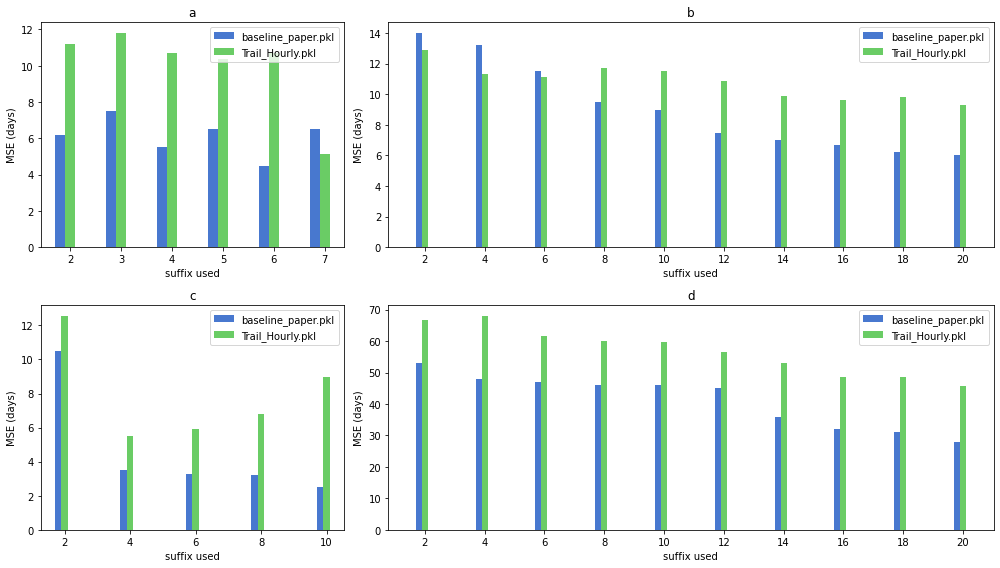

In [24]:
cases = ["baseline_paper.pkl","Trail_Hourly.pkl"]

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 2]},figsize=(14,8))

for i,dataset in enumerate(['a','b','c','d']):
    if dataset == 'a':
        plt.sca(ax[0][0])
    elif dataset == 'b':
        plt.sca(ax[0][1])
    elif dataset == 'c':
        plt.sca(ax[1][0])
    elif dataset == 'd':
        plt.sca(ax[1][1])

    X = np.array(range_dict[dataset])
    steps = [-0.2, 0, 0.2]
    for j,case in enumerate(cases):
        data = list(pickle.load(open(case,"rb")).values())[i];
        plt.bar(X+steps[j], data, width = 0.2, label=case);
    
    plt.xticks(range_dict[dataset])
    plt.legend();
    plt.xlabel("suffix used")
    plt.ylabel("MSE (days)")
    plt.title(dataset)
plt.tight_layout()
plt.show()

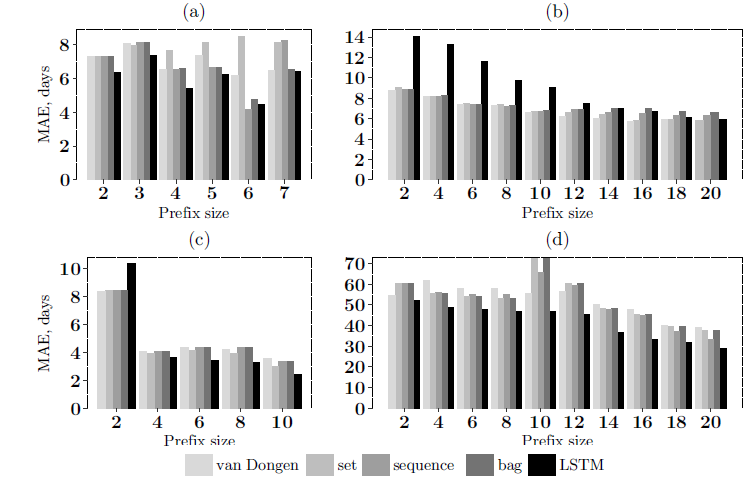

###############################################################################################################################

In [1]:
## Testing

In [5]:
suffix = 6
dataset = df_dict['d']
dataset_preprocessed = preprocess(dataset, suffix+1)
X_train, X_test, X_val, y_train, y_test, y_val = smart_split(dataset_preprocessed,0.67,0.2,suffix,scaling=False)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((494, 6, 383), (494, 2), (123, 6, 383), (123, 2), (300, 6, 383), (300, 2))

In [6]:
# i = np.argwhere((y_train[:,0] >= 0.003611) & (y_train[:,0] < 0.003612))[0][0]
# i = 3
# print(y_train[i,:])
# print(X_train[i,:])

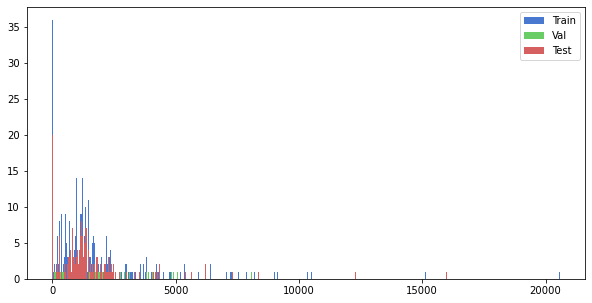

In [7]:
bins = np.arange(0,y_train.max()+24, 24)

plt.figure(figsize=(10,5))
plt.hist(y_train[:,0], bins = bins,label="Train");
plt.hist(y_val[:,0], bins = bins,label="Val");
plt.hist(y_test[:,0], bins = bins, label="Test");
plt.legend()
plt.show()

In [73]:
X_train, y_train = balance_labels_nb(X_train, y_train)
X_val, y_val = balance_labels_nb(X_val, y_val)

0 count: 36 avg: 4 to_del: 32 Act_count: 36
8 count: 6 avg: 4 to_del: 2 Act_count: 6
12 count: 8 avg: 4 to_del: 4 Act_count: 8
14 count: 6 avg: 4 to_del: 2 Act_count: 6
15 count: 9 avg: 4 to_del: 5 Act_count: 9
22 count: 9 avg: 4 to_del: 5 Act_count: 9
23 count: 5 avg: 4 to_del: 1 Act_count: 5
28 count: 7 avg: 4 to_del: 3 Act_count: 7
29 count: 8 avg: 4 to_del: 4 Act_count: 8
31 count: 5 avg: 4 to_del: 1 Act_count: 5
33 count: 7 avg: 4 to_del: 3 Act_count: 7
36 count: 7 avg: 4 to_del: 3 Act_count: 7
39 count: 6 avg: 4 to_del: 2 Act_count: 6
40 count: 14 avg: 4 to_del: 10 Act_count: 14
41 count: 11 avg: 4 to_del: 7 Act_count: 11
43 count: 8 avg: 4 to_del: 4 Act_count: 8
46 count: 5 avg: 4 to_del: 1 Act_count: 5
47 count: 9 avg: 4 to_del: 5 Act_count: 9
48 count: 11 avg: 4 to_del: 7 Act_count: 11
49 count: 9 avg: 4 to_del: 5 Act_count: 9
50 count: 14 avg: 4 to_del: 10 Act_count: 14
54 count: 6 avg: 4 to_del: 2 Act_count: 6
55 count: 8 avg: 4 to_del: 4 Act_count: 8
56 count: 10 avg: 4 to_

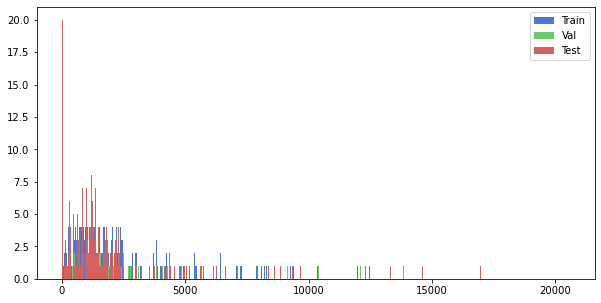

In [74]:
bins = np.arange(0,y_train.max()+24, 24)

plt.figure(figsize=(10,5))
plt.hist(y_train[:,0], bins = bins,label="Train");
plt.hist(y_val[:,0], bins = bins,label="Val");
plt.hist(y_test[:,0], bins = bins, label="Test");
plt.legend()
plt.show()

## Model

In [12]:
def train_notebook(X_train, y_train, X_val, y_val):
    tte_mean_train = np.nanmean(y_train[:,0].astype('float'))
    mean_u = np.nanmean(y_train[:,1].astype('float'))
    init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
    init_alpha = init_alpha/mean_u
    history = History()
    cri = 'loss'
    csv_logger = CSVLogger('training.log', separator=',', append=False)
    es = EarlyStopping(monitor=cri, mode='min', verbose=True, patience=100, restore_best_weights=True)
    mc = ModelCheckpoint('best_model_suff'+str(suffix)+'.h5', monitor=cri, mode='min', verbose=True, save_best_only=True, save_weights_only=True)
    lr_reducer = ReduceLROnPlateau(monitor=cri, factor=0.5, patience=10, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
    n_features = X_train.shape[-1]

    main_input = Input(shape=(None, n_features), name='main_input')
#     mask_input = Masking(mask_value=0, name='mask_input')(main_input)

    l1 = GRU(128, activation='tanh', kernel_initializer=glorot_normal(seed=42), recurrent_dropout=0.2,return_sequences=True)(main_input)
    b0 = BatchNormalization()(l1)
    l11 = GRU(128, activation='tanh',kernel_initializer=glorot_normal(seed=42), recurrent_dropout=0.2,return_sequences=False)(b0)
    b1 = BatchNormalization()(l11)
    l2 = Dense(2, kernel_initializer=glorot_normal(seed=42), name='Dense')(b1)
    b2 = BatchNormalization()(l2)
    output = Lambda(wtte.output_lambda, arguments={"init_alpha":init_alpha,"max_beta_value":100, "scalefactor":0.5})(b2)
    loss = wtte.loss(kind='continuous',reduce_loss=False).loss_function
    model = Model(inputs=[main_input], outputs=[output])
    model.compile(loss=loss, optimizer=Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004, clipvalue=3))

    mg_train = batch_gen(X_train, y_train)
    mg_val = batch_gen(X_val, y_val)
    model.fit_generator(mg_train, 
                    epochs=500,
                    steps_per_epoch = ceil(len(X_train) / batch_size),
                    validation_data=(mg_val),
                    validation_steps= ceil(len(X_val) / batch_size),
                    verbose=True,
                    callbacks=[history,mc,es,csv_logger]
                   )
    return model
model = train_notebook(X_train, y_train, X_val, y_val)

Epoch 1/500
4/4 [==============================] - 1s 312ms/step - loss: 2.4557 - val_loss: 2.0726

Epoch 00001: loss improved from inf to 2.47220, saving model to best_model_suff6.h5
Epoch 2/500
4/4 [==============================] - 0s 27ms/step - loss: 2.2440 - val_loss: 2.2251

Epoch 00002: loss improved from 2.47220 to 2.25577, saving model to best_model_suff6.h5
Epoch 3/500
4/4 [==============================] - 0s 25ms/step - loss: 2.2201 - val_loss: 2.1903

Epoch 00003: loss improved from 2.25577 to 2.23206, saving model to best_model_suff6.h5
Epoch 4/500
4/4 [==============================] - 0s 29ms/step - loss: 2.1541 - val_loss: 1.9968

Epoch 00004: loss improved from 2.23206 to 2.16385, saving model to best_model_suff6.h5
Epoch 5/500
4/4 [==============================] - 0s 26ms/step - loss: 2.1312 - val_loss: 1.9782

Epoch 00005: loss improved from 2.16385 to 2.14130, saving model to best_model_suff6.h5
Epoch 6/500
4/4 [==============================] - 0s 27ms/step - lo

4/4 [==============================] - 0s 28ms/step - loss: 1.5622 - val_loss: 1.8654

Epoch 00050: loss improved from 1.57662 to 1.56279, saving model to best_model_suff6.h5
Epoch 51/500
4/4 [==============================] - 0s 28ms/step - loss: 1.5966 - val_loss: 1.9039

Epoch 00051: loss did not improve from 1.56279
Epoch 52/500
4/4 [==============================] - 0s 28ms/step - loss: 1.5733 - val_loss: 1.9074

Epoch 00052: loss did not improve from 1.56279
Epoch 53/500
4/4 [==============================] - 0s 27ms/step - loss: 1.5416 - val_loss: 1.8771

Epoch 00053: loss improved from 1.56279 to 1.54146, saving model to best_model_suff6.h5
Epoch 54/500
4/4 [==============================] - 0s 27ms/step - loss: 1.5421 - val_loss: 1.8506

Epoch 00054: loss did not improve from 1.54146
Epoch 55/500
4/4 [==============================] - 0s 30ms/step - loss: 1.5146 - val_loss: 1.8703

Epoch 00055: loss improved from 1.54146 to 1.51486, saving model to best_model_suff6.h5
Epoch 56

4/4 [==============================] - 0s 28ms/step - loss: 1.2665 - val_loss: 1.9756

Epoch 00099: loss did not improve from 1.25863
Epoch 100/500
4/4 [==============================] - 0s 29ms/step - loss: 1.2695 - val_loss: 1.9034

Epoch 00100: loss did not improve from 1.25863
Epoch 101/500
4/4 [==============================] - 0s 26ms/step - loss: 1.2801 - val_loss: 1.9598

Epoch 00101: loss did not improve from 1.25863
Epoch 102/500
4/4 [==============================] - 0s 27ms/step - loss: 1.2546 - val_loss: 1.9552

Epoch 00102: loss improved from 1.25863 to 1.25345, saving model to best_model_suff6.h5
Epoch 103/500
4/4 [==============================] - 0s 27ms/step - loss: 1.2260 - val_loss: 1.9004

Epoch 00103: loss improved from 1.25345 to 1.22420, saving model to best_model_suff6.h5
Epoch 104/500
4/4 [==============================] - 0s 27ms/step - loss: 1.2241 - val_loss: 1.9898

Epoch 00104: loss improved from 1.22420 to 1.22253, saving model to best_model_suff6.h5
Epo

4/4 [==============================] - 0s 40ms/step - loss: 1.0542 - val_loss: 2.3334

Epoch 00148: loss did not improve from 1.04758
Epoch 149/500
4/4 [==============================] - 0s 38ms/step - loss: 1.0536 - val_loss: 2.1745

Epoch 00149: loss did not improve from 1.04758
Epoch 150/500
4/4 [==============================] - 0s 37ms/step - loss: 1.0460 - val_loss: 2.2919

Epoch 00150: loss improved from 1.04758 to 1.04313, saving model to best_model_suff6.h5
Epoch 151/500
4/4 [==============================] - 0s 35ms/step - loss: 1.0407 - val_loss: 2.2339

Epoch 00151: loss improved from 1.04313 to 1.03819, saving model to best_model_suff6.h5
Epoch 152/500
4/4 [==============================] - 0s 36ms/step - loss: 1.0278 - val_loss: 2.3239

Epoch 00152: loss improved from 1.03819 to 1.02528, saving model to best_model_suff6.h5
Epoch 153/500
4/4 [==============================] - 0s 36ms/step - loss: 1.0066 - val_loss: 2.3408

Epoch 00153: loss improved from 1.02528 to 1.00386

Epoch 198/500
4/4 [==============================] - 0s 39ms/step - loss: 0.8782 - val_loss: 2.7227

Epoch 00198: loss did not improve from 0.85451
Epoch 199/500
4/4 [==============================] - 0s 40ms/step - loss: 0.8918 - val_loss: 2.6943

Epoch 00199: loss did not improve from 0.85451
Epoch 200/500
4/4 [==============================] - 0s 38ms/step - loss: 0.8736 - val_loss: 2.6339

Epoch 00200: loss did not improve from 0.85451
Epoch 201/500
4/4 [==============================] - 0s 37ms/step - loss: 0.8760 - val_loss: 2.5720

Epoch 00201: loss did not improve from 0.85451
Epoch 202/500
4/4 [==============================] - 0s 37ms/step - loss: 0.8987 - val_loss: 2.5218

Epoch 00202: loss did not improve from 0.85451
Epoch 203/500
4/4 [==============================] - 0s 37ms/step - loss: 0.8462 - val_loss: 2.5067

Epoch 00203: loss improved from 0.85451 to 0.84277, saving model to best_model_suff6.h5
Epoch 204/500
4/4 [==============================] - 0s 38ms/step - los

4/4 [==============================] - 0s 38ms/step - loss: 0.7633 - val_loss: 2.7101

Epoch 00250: loss improved from 0.75945 to 0.75746, saving model to best_model_suff6.h5
Epoch 251/500
4/4 [==============================] - 0s 37ms/step - loss: 0.7468 - val_loss: 2.7862

Epoch 00251: loss improved from 0.75746 to 0.74155, saving model to best_model_suff6.h5
Epoch 252/500
4/4 [==============================] - 0s 44ms/step - loss: 0.7272 - val_loss: 2.7898

Epoch 00252: loss improved from 0.74155 to 0.72239, saving model to best_model_suff6.h5
Epoch 253/500
4/4 [==============================] - 0s 35ms/step - loss: 0.7269 - val_loss: 2.8065

Epoch 00253: loss improved from 0.72239 to 0.72162, saving model to best_model_suff6.h5
Epoch 254/500
4/4 [==============================] - 0s 37ms/step - loss: 0.7469 - val_loss: 2.7507

Epoch 00254: loss did not improve from 0.72162
Epoch 255/500
4/4 [==============================] - 0s 37ms/step - loss: 0.7940 - val_loss: 2.8315

Epoch 002


Epoch 00302: loss did not improve from 0.66321
Epoch 303/500
4/4 [==============================] - 0s 37ms/step - loss: 0.7609 - val_loss: 2.7740

Epoch 00303: loss did not improve from 0.66321
Epoch 304/500
4/4 [==============================] - 0s 36ms/step - loss: 0.7475 - val_loss: 2.7694

Epoch 00304: loss did not improve from 0.66321
Epoch 305/500
4/4 [==============================] - 0s 39ms/step - loss: 0.7412 - val_loss: 2.7587

Epoch 00305: loss did not improve from 0.66321
Epoch 306/500
4/4 [==============================] - 0s 37ms/step - loss: 0.7105 - val_loss: 2.7391

Epoch 00306: loss did not improve from 0.66321
Epoch 307/500
4/4 [==============================] - 0s 37ms/step - loss: 0.6852 - val_loss: 2.8118

Epoch 00307: loss did not improve from 0.66321
Epoch 308/500
4/4 [==============================] - 0s 41ms/step - loss: 0.6793 - val_loss: 2.9145

Epoch 00308: loss did not improve from 0.66321
Epoch 309/500
4/4 [==============================] - 0s 39ms/ste

4/4 [==============================] - 0s 37ms/step - loss: 0.6671 - val_loss: 3.0821

Epoch 00357: loss did not improve from 0.60750
Epoch 358/500
4/4 [==============================] - 0s 36ms/step - loss: 0.6907 - val_loss: 3.1089

Epoch 00358: loss did not improve from 0.60750
Epoch 359/500
4/4 [==============================] - 0s 39ms/step - loss: 0.6784 - val_loss: 3.2522

Epoch 00359: loss did not improve from 0.60750
Epoch 360/500
4/4 [==============================] - 0s 36ms/step - loss: 0.6729 - val_loss: 3.0072

Epoch 00360: loss did not improve from 0.60750
Epoch 361/500
4/4 [==============================] - 0s 35ms/step - loss: 0.6162 - val_loss: 2.9709

Epoch 00361: loss did not improve from 0.60750
Epoch 362/500
4/4 [==============================] - 0s 35ms/step - loss: 0.6206 - val_loss: 3.0684

Epoch 00362: loss did not improve from 0.60750
Epoch 363/500
4/4 [==============================] - 0s 35ms/step - loss: 0.6548 - val_loss: 3.0613

Epoch 00363: loss did not

4/4 [==============================] - 0s 38ms/step - loss: 0.6008 - val_loss: 3.1887

Epoch 00412: loss did not improve from 0.58015
Epoch 413/500
4/4 [==============================] - 0s 39ms/step - loss: 0.6376 - val_loss: 3.2269

Epoch 00413: loss did not improve from 0.58015
Epoch 414/500
4/4 [==============================] - 0s 37ms/step - loss: 0.6205 - val_loss: 2.9931

Epoch 00414: loss did not improve from 0.58015
Epoch 415/500
4/4 [==============================] - 0s 42ms/step - loss: 0.6074 - val_loss: 3.0936

Epoch 00415: loss did not improve from 0.58015
Epoch 416/500
4/4 [==============================] - 0s 38ms/step - loss: 0.6037 - val_loss: 2.9531

Epoch 00416: loss did not improve from 0.58015
Epoch 417/500
4/4 [==============================] - 0s 38ms/step - loss: 0.6039 - val_loss: 3.0843

Epoch 00417: loss did not improve from 0.58015
Epoch 418/500
4/4 [==============================] - 0s 37ms/step - loss: 0.5893 - val_loss: 3.1667

Epoch 00418: loss did not


Epoch 00466: loss did not improve from 0.55380
Epoch 467/500
4/4 [==============================] - 0s 37ms/step - loss: 0.5684 - val_loss: 3.3784

Epoch 00467: loss did not improve from 0.55380
Epoch 468/500
4/4 [==============================] - 0s 40ms/step - loss: 0.5680 - val_loss: 3.1751

Epoch 00468: loss did not improve from 0.55380
Epoch 469/500
4/4 [==============================] - 0s 37ms/step - loss: 0.5739 - val_loss: 3.3511

Epoch 00469: loss did not improve from 0.55380
Epoch 470/500
4/4 [==============================] - 0s 37ms/step - loss: 0.5515 - val_loss: 3.4603

Epoch 00470: loss improved from 0.55380 to 0.54431, saving model to best_model_suff6.h5
Epoch 471/500
4/4 [==============================] - 0s 36ms/step - loss: 0.5747 - val_loss: 3.3792

Epoch 00471: loss did not improve from 0.54431
Epoch 472/500
4/4 [==============================] - 0s 37ms/step - loss: 0.5670 - val_loss: 3.4181

Epoch 00472: loss did not improve from 0.54431
Epoch 473/500
4/4 [====

59.216439749034976


0.000000       13
161.169706      4
879.251086      4
589.046642      2
964.231527      2
               ..
951.784421      1
702.080112      1
1584.395178     1
2455.311702     1
1107.437338     1
Name: predicted_mode, Length: 275, dtype: int64

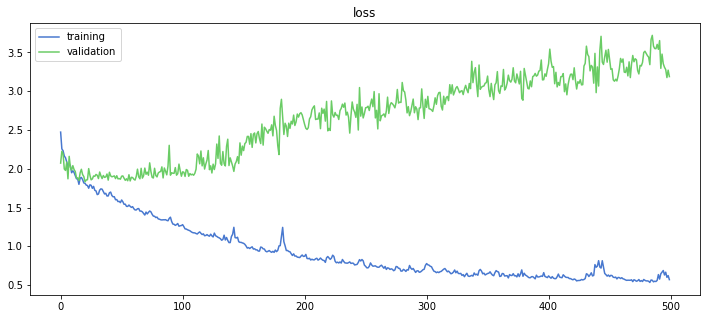

In [13]:
model.load_weights('best_model_suff'+str(suffix)+'.h5')
history = pd.read_csv('training.log', sep=',', engine='python')

test_result_df, mae = evaluating(X_test,y_test, model)
print(mae)
plt.figure(figsize = (12,5));
plt.plot(history['loss'], label='training');
plt.plot(history['val_loss'],label='validation');
plt.title('loss');
plt.legend();
test_result_df["predicted_mode"].value_counts()

In [49]:
# # build the model: 
# print('Build model...')
# n_features = X_train.shape[-1]
# main_input = Input(shape=(None, n_features), name='main_input')
# # train a 2-layer LSTM with one shared layer
# l1 = LSTM(128, implementation=2, kernel_initializer='glorot_uniform', return_sequences=True, dropout=0.2)(main_input) # the shared layer
# b1 = BatchNormalization()(l1)
# l2_2 = LSTM(128, implementation=2, kernel_initializer='glorot_uniform', return_sequences=False, dropout=0.2)(b1) # the layer specialized in time prediction
# b2_2 = BatchNormalization()(l2_2)
# time_output = Dense(1, kernel_initializer='glorot_uniform', name='time_output')(b2_2)

# model = Model(inputs=[main_input], outputs=[time_output])

# opt = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004, clipvalue=3)

# model.compile(loss={'time_output':'mae'}, optimizer=opt)
# early_stopping = EarlyStopping(monitor='val_loss', patience=42)
# model_checkpoint = ModelCheckpoint('output_files/models/model_{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
# lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
# print(model.summary())
# model.fit(X_train, {'time_output':y_train[:,0]}, validation_data=(X_val,y_val[:,0]), verbose=2, callbacks=[early_stopping, model_checkpoint, lr_reducer], batch_size=128, epochs=500)

No handles with labels found to put in legend.


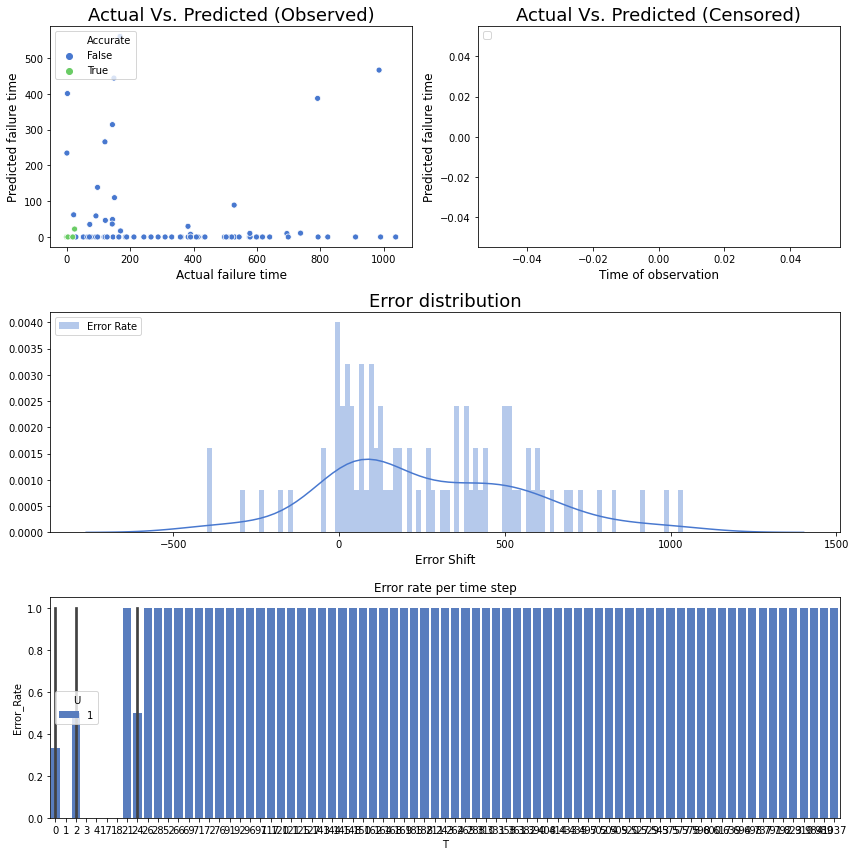

In [48]:
plot_predictions_insights(test_result_df)

In [50]:
# mg_test = batch_gen_test(X_test)
# nb_samples = len(X_test)
# test_predict = model.predict_generator(mg_test, steps= ceil(len(X_test) / batch_size))
# test_results_df = pd.DataFrame(y_test[:,0], columns=['T'])
# test_results_df['predicted_mode'] =  test_predict
# mae = mean_absolute_error(test_results_df['T'], test_results_df['predicted_mode']) / 24
# print(mae, test_results_df)

# plt.figure(figsize = (12,5));
# plt.plot(history['loss'], label='training');
# plt.plot(history['val_loss'],label='validation');
# plt.title('loss');
# plt.legend();
# test_result_df["predicted_mode"].value_counts()

No handles with labels found to put in legend.


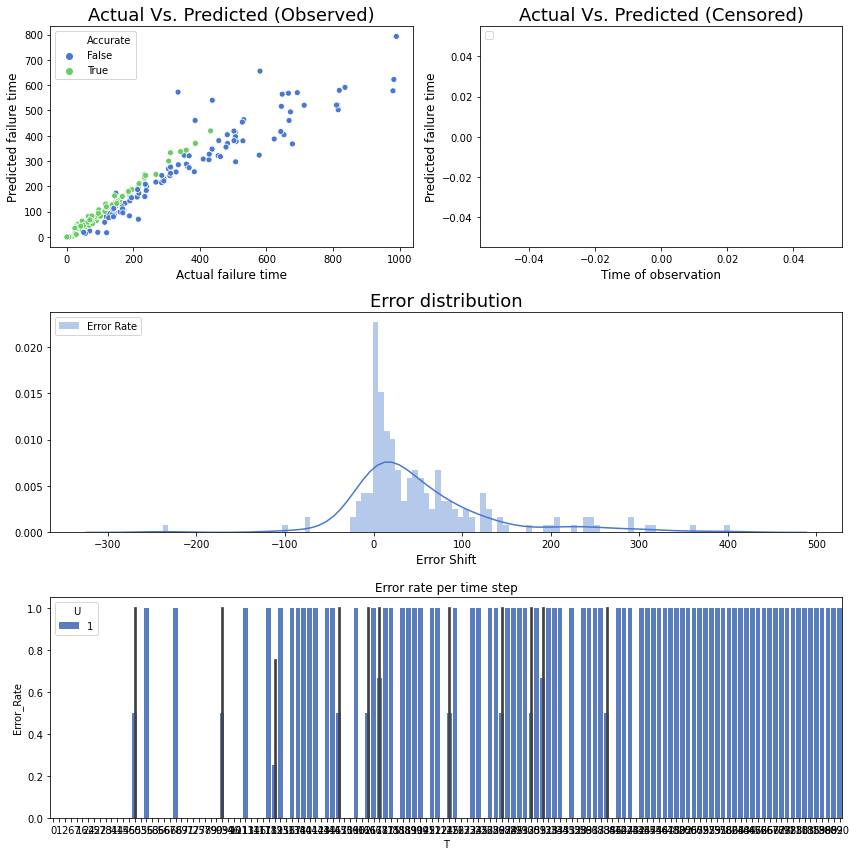

In [29]:
test_result_df, mae = evaluating(X_train,y_train, model)
plot_predictions_insights(test_result_df)

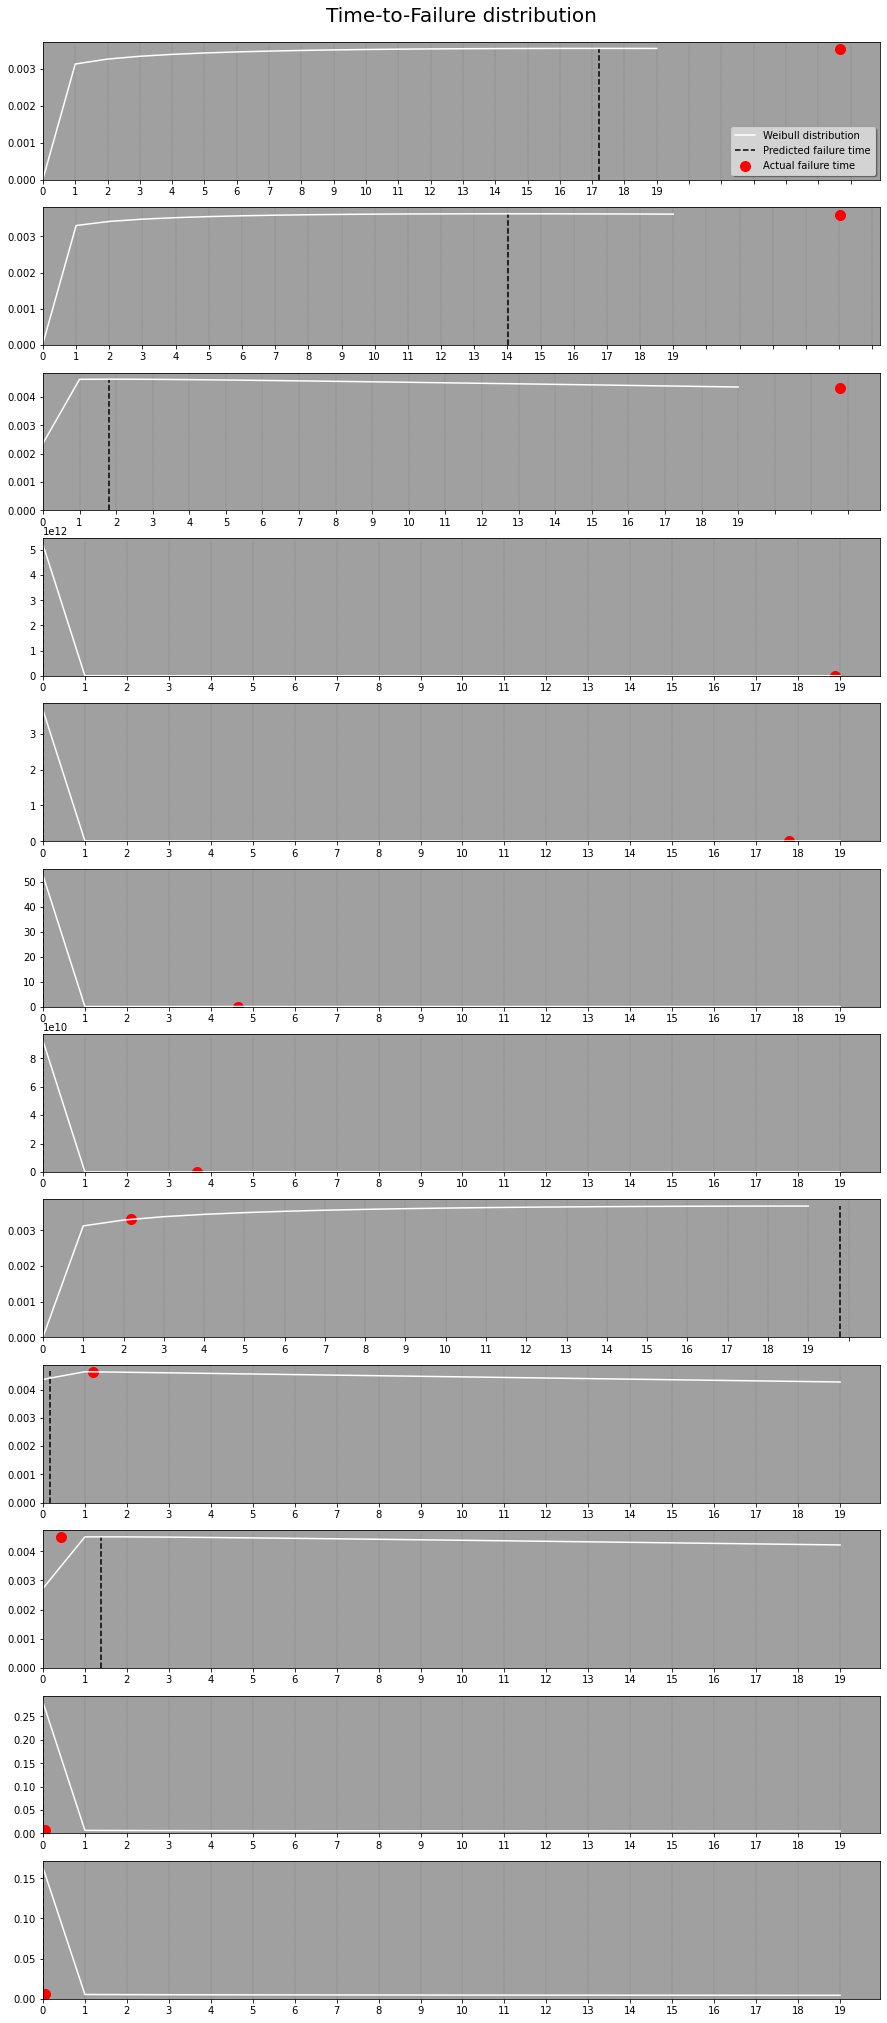

In [306]:
from t2e_utils import *
plot_top_predictions(test_result_df,15,top_feature="T",ascending=False, U=1,accurate=True)